<a href="https://colab.research.google.com/github/DevBatra05/DeepLearningLab/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U "tensorflow[and-cuda]" kagglehub scikit-learn seaborn matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.


In [ ]:
import os, sys
os.kill(os.getpid(), 9)


In [1]:
import numpy as np
import tensorflow as tf

print("NumPy version :", np.__version__)
print("TF version    :", tf.__version__)
print("GPU devices   :", tf.config.list_physical_devices('GPU'))


NumPy version : 2.0.2
TF version    : 2.20.0
GPU devices   : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import shutil
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Imports complete.")


Imports complete.


In [3]:
# Download dataset
path = kagglehub.dataset_download("aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented")
print("Dataset downloaded to:", path)

from zipfile import ZipFile
p = Path(path)

# Unzip if needed
if p.is_file() and p.suffix == ".zip":
    extract_dir = p.with_suffix("")
    if not extract_dir.exists():
        with ZipFile(p, 'r') as z:
            z.extractall(extract_dir)
    DATASET_ROOT = extract_dir
else:
    DATASET_ROOT = p

print("DATASET_ROOT:", DATASET_ROOT)


100%|██████████| 398M/398M [00:19<00:00, 21.7MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented/versions/1
DATASET_ROOT: /root/.cache/kagglehub/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented/versions/1


In [5]:
from pathlib import Path

def find_image_root(root):
    root = Path(root)
    # search depth up to 2
    candidates = [root] + list(root.glob("*")) + sum(
        [list(d.glob("*")) for d in root.glob("*") if d.is_dir()],
        []
    )
    for sub in candidates:
        if sub.is_dir():
            subdirs = [d for d in sub.iterdir() if d.is_dir()]
            if len(subdirs) >= 2:
                for d in subdirs:
                    if any(d.glob("*.jpg")) or any(d.glob("*.jpeg")) or any(d.glob("*.png")):
                        return sub
    return None

IMAGE_DIR = find_image_root(DATASET_ROOT)
print("IMAGE_DIR:", IMAGE_DIR)
print("Class folders:", [d.name for d in IMAGE_DIR.iterdir() if d.is_dir()])


IMAGE_DIR: /root/.cache/kagglehub/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented/versions/1/combined_images
Class folders: ['VeryMildDemented', 'NonDemented', 'MildDemented', 'ModerateDemented']


In [6]:
import shutil
from sklearn.model_selection import train_test_split

WORK_DIR = Path("/content/alzheimers_work")
train_dir = WORK_DIR / "train"
val_dir   = WORK_DIR / "val"
test_dir  = WORK_DIR / "test"

def create_splits(src_dir, train_dir, val_dir, test_dir,
                  test_size=0.15, val_size=0.15, seed=42):
    src_dir = Path(src_dir)

    # if already split, reuse
    if train_dir.exists() and val_dir.exists() and test_dir.exists():
        print("Splits already exist. Using existing folders.")
        return

    # fresh work dir
    if WORK_DIR.exists():
        shutil.rmtree(WORK_DIR)
    train_dir.mkdir(parents=True, exist_ok=True)
    val_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)

    for cls in [p for p in src_dir.iterdir() if p.is_dir()]:
        images = sorted([str(x) for x in cls.glob("*")
                         if x.suffix.lower() in [".jpg", ".jpeg", ".png"]])
        if len(images) == 0:
            continue

        # split → train+val vs test
        tr_val, te = train_test_split(images, test_size=test_size,
                                      random_state=seed, stratify=None)
        # split → train vs val
        tr, va = train_test_split(tr_val,
                                  test_size=val_size/(1-test_size),
                                  random_state=seed,
                                  stratify=None)

        for dest, files in [(train_dir, tr), (val_dir, va), (test_dir, te)]:
            cls_dest = dest / cls.name
            cls_dest.mkdir(parents=True, exist_ok=True)
            for f in files:
                shutil.copy(f, cls_dest / Path(f).name)

create_splits(IMAGE_DIR, train_dir, val_dir, test_dir)
print("Splits ready at:", WORK_DIR)


Splits ready at: /content/alzheimers_work


In [7]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

val_gen = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_indices = train_gen.class_indices
print("Class indices:", class_indices)
num_classes = len(class_indices)


Found 30799 images belonging to 4 classes.
Found 6601 images belonging to 4 classes.
Found 6600 images belonging to 4 classes.
Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_vgg16_model(img_size=(224, 224), num_classes=4,
                      fine_tune_at=15, lr=1e-4):
    base = VGG16(weights="imagenet", include_top=False,
                 input_shape=(*img_size, 3))
    base.trainable = True

    # freeze all but last `fine_tune_at` layers
    for layer in base.layers[:-fine_tune_at]:
        layer.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = build_vgg16_model(IMG_SIZE, num_classes=num_classes,
                          fine_tune_at=15, lr=1e-4)
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,02

 Total params: 14,849,092 (56.64 MB)

 Trainable params: 14,809,348 (56.49 MB)

 Non-trainable params: 39,744 (155.25 KB)

In [9]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# class weights
y_train = train_gen.classes
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", class_weights)

# training with callbacks
EPOCHS = 20
checkpoint_path = str(WORK_DIR / "best_vgg16.h5")

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor="val_accuracy",
                    save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=8,
                  restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                      patience=3, verbose=1)
]

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

print("Best model saved to:", checkpoint_path)


Class weights: {0: 1.0999642857142857, 1: 1.0999642857142857, 2: 0.8594430181939948, 3: 0.9821109693877551}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.4916 - loss: 1.0921
Epoch 1: val_accuracy improved from -inf to 0.47053, saving model to /content/alzheimers_work/best_vgg16.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 579s 563ms/step - accuracy: 0.4917 - loss: 1.0919 - val_accuracy: 0.4705 - val_loss: 6.0570 - learning_rate: 1.0000e-04
Epoch 2/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.7497 - loss: 0.5524
Epoch 2: val_accuracy improved from 0.47053 to 0.68414, saving model to /content/alzheimers_work/best_vgg16.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 506s 525ms/step - accuracy: 0.7498 - loss: 0.5524 - val_accuracy: 0.6841 - val_loss: 0.7949 - learning_rate: 1.0000e-04
Epoch 3/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8620 - loss: 0.3225
Epoch 3: val_accuracy improved from 0.68414 to 0.79458, saving model to /content/alzheimers_work/best_vgg16.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 508s 527ms/step - accuracy: 0.8621 - loss: 0.3224 - val_accuracy: 0.7946 - val_loss: 0.6131 - learning_rate: 1.0000e-04
Epoch 4/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9210 - loss: 0.1943
Epoch 4: val_accuracy did not improve from 0.79458
963/963 ━━━━━━━━━━━━━━━━━━━━ 508s 527ms/step - accuracy: 0.9210 - loss: 0.1943 - val_accuracy: 0.7032 - val_loss: 1.4498 - learning_rate: 1.0000e-04
Epoch 5/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9451 - loss: 0.1364
Epoch 5: val_accuracy improved from 0.79458 to 0.97546, saving model to /content/alzheimers_work/best_vgg16.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 514s 533ms/step - accuracy: 0.9451 - loss: 0.1364 - val_accuracy: 0.9755 - val_loss: 0.0605 - learning_rate: 1.0000e-04
Epoch 6/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9612 - loss: 0.1011
Epoch 6: val_accuracy did not improve from 0.97546
963/963 ━━━━━━━━━━━━━━━━━━━━ 507s 526ms/step - accuracy: 0.9612 - loss: 0.1011 - val_accuracy: 0.8571 - val_loss: 0.4006 - learning_rate: 1.0000e-04
Epoch 7/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9702 - loss: 0.0807
Epoch 7: val_accuracy did not improve from 0.97546
963/963 ━━━━━━━━━━━━━━━━━━━━ 505s 524ms/step - accuracy: 0.9702 - loss: 0.0807 - val_accuracy: 0.9308 - val_loss: 0.1739 - learning_rate: 1.0000e-04
Epoch 8/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9747 - loss: 0.0707
Epoch 8: val_accuracy improved from 0.97546 to 0.99227, saving model to /content/alzheimers_work/best_vgg16.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 507s 526ms/step - accuracy: 0.9747 - loss: 0.0707 - val_accuracy: 0.9923 - val_loss: 0.0232 - learning_rate: 1.0000e-04
Epoch 9/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9791 - loss: 0.0600
Epoch 9: val_accuracy did not improve from 0.99227
963/963 ━━━━━━━━━━━━━━━━━━━━ 504s 523ms/step - accuracy: 0.9791 - loss: 0.0600 - val_accuracy: 0.9589 - val_loss: 0.1292 - learning_rate: 1.0000e-04
Epoch 10/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9782 - loss: 0.0589
Epoch 10: val_accuracy did not improve from 0.99227
963/963 ━━━━━━━━━━━━━━━━━━━━ 503s 522ms/step - accuracy: 0.9782 - loss: 0.0589 - val_accuracy: 0.8667 - val_loss: 0.4855 - learning_rate: 1.0000e-04
Epoch 11/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9798 - loss: 0.0533
Epoch 11: val_accuracy did not improve from 0.99227

Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
963/963 ━━━━━━━━━━━━━━━━━━━━ 505s 525ms/step - accurac

963/963 ━━━━━━━━━━━━━━━━━━━━ 503s 522ms/step - accuracy: 0.9941 - loss: 0.0177 - val_accuracy: 0.9967 - val_loss: 0.0103 - learning_rate: 5.0000e-05
Epoch 14/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9913 - loss: 0.0234
Epoch 14: val_accuracy improved from 0.99667 to 0.99833, saving model to /content/alzheimers_work/best_vgg16.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 562s 522ms/step - accuracy: 0.9913 - loss: 0.0234 - val_accuracy: 0.9983 - val_loss: 0.0050 - learning_rate: 5.0000e-05
Epoch 15/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9930 - loss: 0.0181
Epoch 15: val_accuracy did not improve from 0.99833
963/963 ━━━━━━━━━━━━━━━━━━━━ 514s 533ms/step - accuracy: 0.9930 - loss: 0.0181 - val_accuracy: 0.9983 - val_loss: 0.0045 - learning_rate: 5.0000e-05
Epoch 16/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9944 - loss: 0.0146
Epoch 16: val_accuracy improved from 0.99833 to 0.99924, saving model to /content/alzheimers_work/best_vgg16.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 514s 534ms/step - accuracy: 0.9944 - loss: 0.0146 - val_accuracy: 0.9992 - val_loss: 0.0027 - learning_rate: 5.0000e-05
Epoch 17/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9932 - loss: 0.0180
Epoch 17: val_accuracy did not improve from 0.99924
963/963 ━━━━━━━━━━━━━━━━━━━━ 512s 532ms/step - accuracy: 0.9932 - loss: 0.0180 - val_accuracy: 0.9906 - val_loss: 0.0294 - learning_rate: 5.0000e-05
Epoch 18/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9950 - loss: 0.0165
Epoch 18: val_accuracy did not improve from 0.99924
963/963 ━━━━━━━━━━━━━━━━━━━━ 510s 530ms/step - accuracy: 0.9950 - loss: 0.0165 - val_accuracy: 0.9962 - val_loss: 0.0105 - learning_rate: 5.0000e-05
Epoch 19/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9949 - loss: 0.0140
Epoch 19: val_accuracy did not improve from 0.99924

Epoch 19: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
963/963 ━━━━━━━━━━━━━━━━━━━━ 515s 535ms/step - accur

963/963 ━━━━━━━━━━━━━━━━━━━━ 513s 532ms/step - accuracy: 0.9976 - loss: 0.0066 - val_accuracy: 0.9995 - val_loss: 0.0016 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 20.
Best model saved to: /content/alzheimers_work/best_vgg16.h5


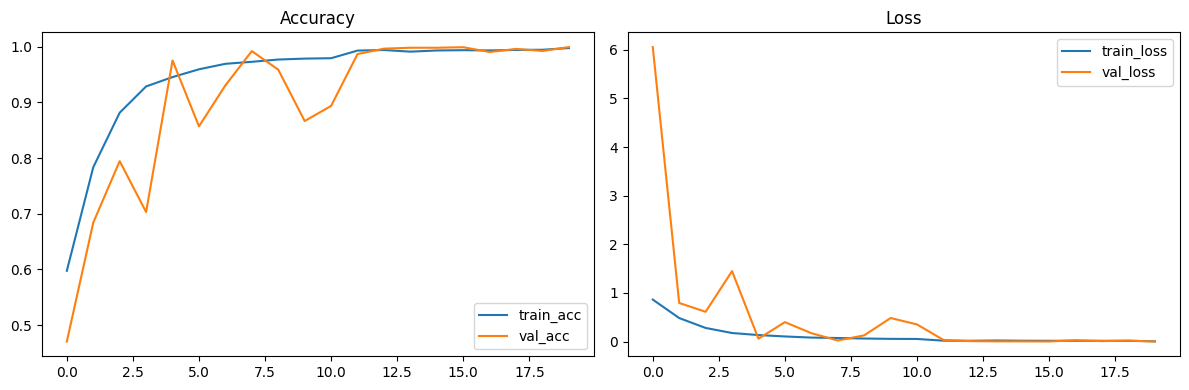

207/207 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step
Test accuracy: 0.9992


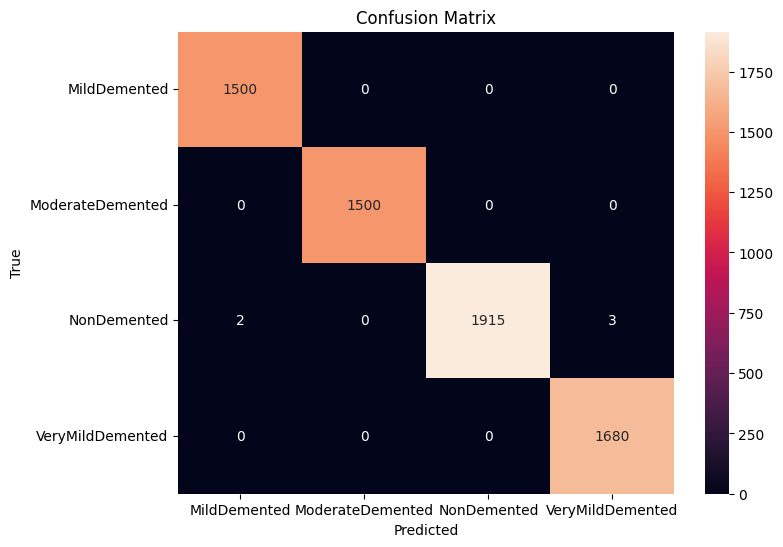

Classification report:
                   precision    recall  f1-score   support

    MildDemented     0.9987    1.0000    0.9993      1500
ModerateDemented     1.0000    1.0000    1.0000      1500
     NonDemented     1.0000    0.9974    0.9987      1920
VeryMildDemented     0.9982    1.0000    0.9991      1680

        accuracy                         0.9992      6600
       macro avg     0.9992    0.9993    0.9993      6600
    weighted avg     0.9992    0.9992    0.9992      6600

Precision per class: [0.99866844 1.         1.         0.99821747]
Recall per class   : [1.         1.         0.99739583 1.        ]
F1 per class       : [0.99933378 1.         0.99869622 0.99910794]
Support per class  : [1500 1500 1920 1680]


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# load best weights
model.load_weights(checkpoint_path)

# training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# test evaluation
test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

test_acc = accuracy_score(y_true, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred,
                               target_names=labels, digits=4)
print("Classification report:\n", report)

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, zero_division=0
)
print("Precision per class:", precision)
print("Recall per class   :", recall)
print("F1 per class       :", f1)
print("Support per class  :", support)


In [11]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/Alzheimer_Model"
!cp "/content/alzheimers_work/best_vgg16.h5" "/content/drive/MyDrive/Alzheimer_Model/best_vgg16.h5"
!cp "/content/final_backup_model.h5" "/content/drive/MyDrive/Alzheimer_Model/final_backup_model.h5"

print("Models copied to Google Drive:")
!ls "/content/drive/MyDrive/Alzheimer_Model"


Mounted at /content/drive
cp: cannot stat '/content/final_backup_model.h5': No such file or directory
Models copied to Google Drive:
best_vgg16.h5


In [12]:
model.save("/content/final_backup_model.h5")
!cp "/content/final_backup_model.h5" "/content/drive/MyDrive/Alzheimer_Model/final_backup_model.h5"


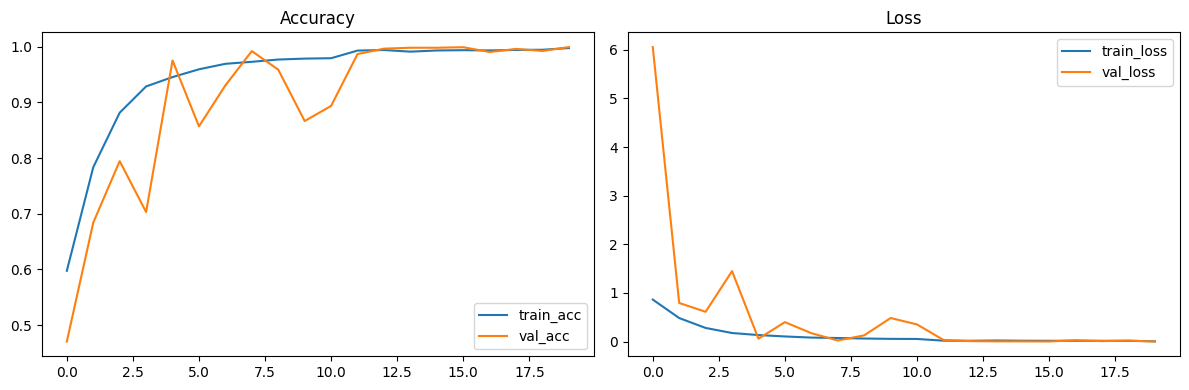

207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 171ms/step

Test accuracy: 0.9992



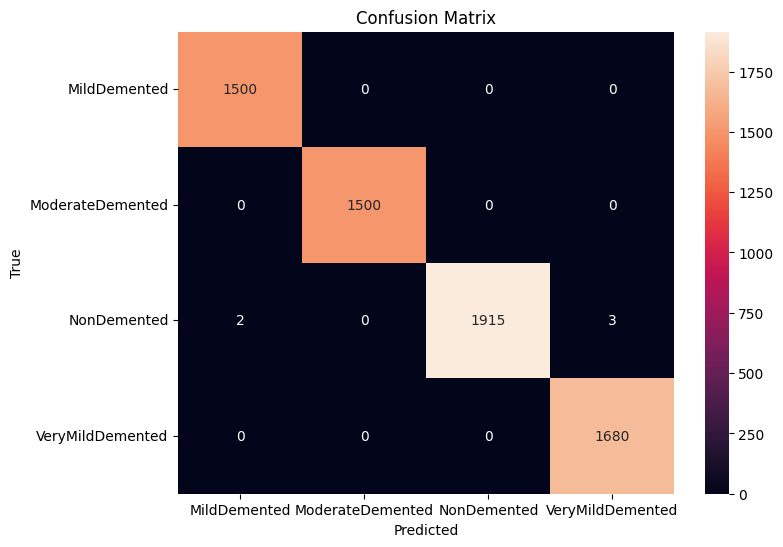

Classification report:
                   precision    recall  f1-score   support

    MildDemented     0.9987    1.0000    0.9993      1500
ModerateDemented     1.0000    1.0000    1.0000      1500
     NonDemented     1.0000    0.9974    0.9987      1920
VeryMildDemented     0.9982    1.0000    0.9991      1680

        accuracy                         0.9992      6600
       macro avg     0.9992    0.9993    0.9993      6600
    weighted avg     0.9992    0.9992    0.9992      6600

Precision per class: [0.99866844 1.         1.         0.99821747]
Recall per class   : [1.         1.         0.99739583 1.        ]
F1 per class       : [0.99933378 1.         0.99869622 0.99910794]
Support per class  : [1500 1500 1920 1680]


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# 1. Load best weights
model.load_weights(checkpoint_path)

# 2. Plot training curves ONLY if we still have `history`
if 'history' in globals() and hasattr(history, 'history'):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history.get("accuracy", []), label="train_acc")
    plt.plot(history.history.get("val_accuracy", []), label="val_acc")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history.get("loss", []), label="train_loss")
    plt.plot(history.history.get("val_loss", []), label="val_loss")
    plt.title("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No `history` object found (maybe runtime restarted). Skipping training curves.\n")

# 3. Test evaluation
test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

test_acc = accuracy_score(y_true, y_pred)
print(f"\nTest accuracy: {test_acc:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
report = classification_report(y_true, y_pred,
                               target_names=labels, digits=4)
print("Classification report:\n", report)

# Precision / Recall / F1 / Support arrays
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, zero_division=0
)
print("Precision per class:", precision)
print("Recall per class   :", recall)
print("F1 per class       :", f1)
print("Support per class  :", support)


In [14]:
from tensorflow.keras.preprocessing import image

final_model_path = str(WORK_DIR / "final_vgg16_model.h5")
model.save(final_model_path)
print("Saved final model to:", final_model_path)

def predict_single_image(img_path,
                         model_obj=model,          # use already-loaded model
                         target_size=(224,224),
                         class_indices=class_indices):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    probs = model_obj.predict(x)[0]
    idx = int(np.argmax(probs))
    inv = {v:k for k,v in class_indices.items()}
    label = inv[idx]
    return label, float(probs[idx]), probs


Saved final model to: /content/alzheimers_work/final_vgg16_model.h5


In [15]:
!cp "/content/alzheimers_work/final_vgg16_model.h5" "/content/drive/MyDrive/Alzheimer_Model/final_vgg16_model.h5"
!ls "/content/drive/MyDrive/Alzheimer_Model"


best_vgg16.h5  final_backup_model.h5  final_vgg16_model.h5


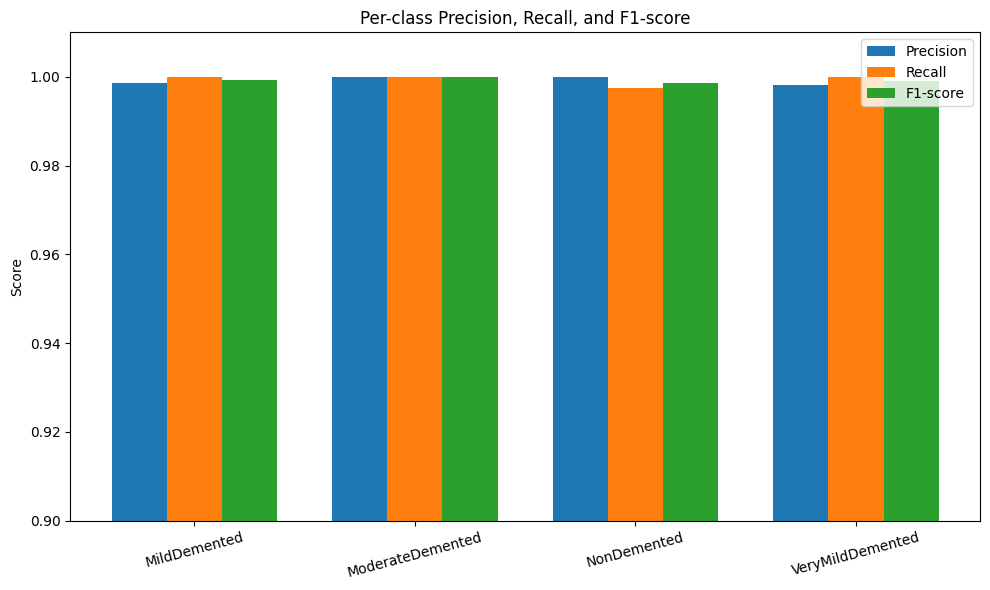

Saved PRF bar chart to: /content/alzheimers_work/precision_recall_f1_per_class.png


In [16]:
x = np.arange(len(labels))  # class index positions
width = 0.25                # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width, precision, width, label="Precision")
plt.bar(x,         recall,   width, label="Recall")
plt.bar(x + width, f1,       width, label="F1-score")

plt.xticks(x, labels, rotation=15)
plt.ylim(0.9, 1.01)
plt.ylabel("Score")
plt.title("Per-class Precision, Recall, and F1-score")
plt.legend()
plt.tight_layout()

prf_path = str(WORK_DIR / "precision_recall_f1_per_class.png")
plt.savefig(prf_path, dpi=300)
plt.show()

print("Saved PRF bar chart to:", prf_path)


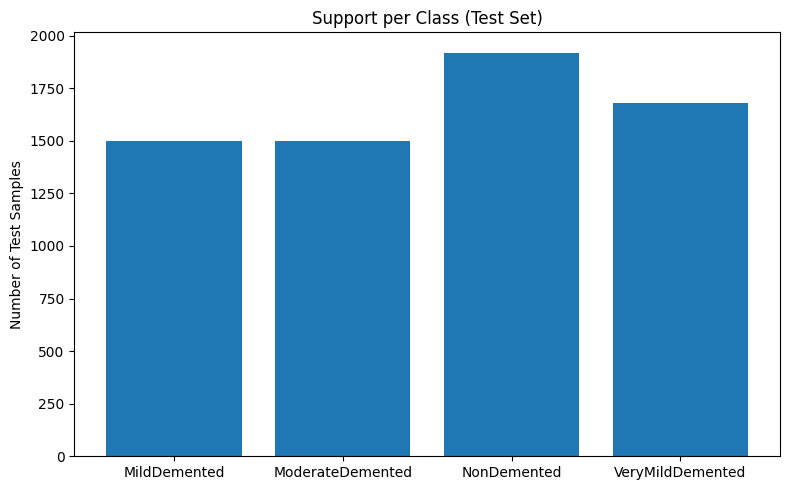

Saved support plot to: /content/alzheimers_work/support_per_class.png


In [17]:
plt.figure(figsize=(8,5))
plt.bar(labels, support)
plt.ylabel("Number of Test Samples")
plt.title("Support per Class (Test Set)")
plt.tight_layout()

support_path = str(WORK_DIR / "support_per_class.png")
plt.savefig(support_path, dpi=300)
plt.show()

print("Saved support plot to:", support_path)


Using model already in memory.
Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Upload an MRI image file (jpg/png)...


Saving VeryMildDemented.jpg to VeryMildDemented.jpg

File received: /content/VeryMildDemented.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


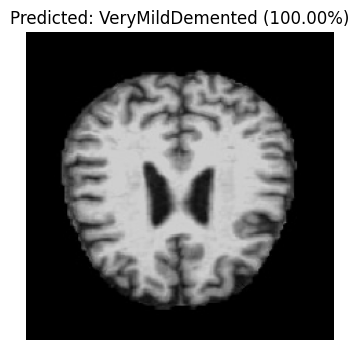

Predicted label: VeryMildDemented
Confidence: 100.00%
Probabilities (in class order):
  MildDemented: 0.00%
  ModerateDemented: 0.00%
  NonDemented: 0.00%
  VeryMildDemented: 100.00%


In [18]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# === 1. Choose which model file to use ===
# If you are in the same session where you trained:
#   - 'model' and 'class_indices' already exist
# If you opened a NEW session, uncomment the load_model lines instead.

USE_EXISTING_MODEL = True   # set False if you restarted Colab and need to load from .h5

if USE_EXISTING_MODEL:
    model_for_inference = model  # already trained in this session
    print("Using model already in memory.")
else:
    # --- CHANGE THIS PATH IF YOU LOAD FROM DRIVE ---
    # Example if you saved to Drive:
    # model_path = "/content/drive/MyDrive/Alzheimer_Model/best_vgg16.h5"
    model_path = "/content/alzheimers_work/final_vgg16_model.h5"
    model_for_inference = load_model(model_path)
    print("Loaded model from:", model_path)

# Make sure class_indices exists (this was created by train_gen)
print("Class indices:", class_indices)

# === 2. Define prediction function ===
def predict_single_image_and_show(img_path,
                                  model_obj=model_for_inference,
                                  target_size=(224, 224),
                                  class_indices=class_indices):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Predict
    probs = model_obj.predict(x)[0]
    idx = int(np.argmax(probs))
    inv_map = {v: k for k, v in class_indices.items()}
    label = inv_map[idx]
    confidence = float(probs[idx]) * 100.0  # percentage

    # Show image with title
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {label} ({confidence:.2f}%)")
    plt.show()

    # Also print full probabilities
    print("Predicted label:", label)
    print(f"Confidence: {confidence:.2f}%")
    print("Probabilities (in class order):")
    for c_idx, cls_name in sorted(inv_map.items()):
        print(f"  {cls_name}: {probs[c_idx]*100:.2f}%")

    return label, confidence, probs

# === 3. Upload an MRI image and predict ===
print("Upload an MRI image file (jpg/png)...")
uploaded = files.upload()  # opens file chooser

for fname in uploaded.keys():
    img_path = "/content/" + fname
    print("\nFile received:", img_path)
    label, conf, probs = predict_single_image_and_show(img_path)


In [19]:
USE_EXISTING_MODEL = False  # because we want to load from Drive

model_path = "/content/drive/MyDrive/Alzheimer_Model/best_vgg16.h5"
model_for_inference = load_model(model_path)
print("Loaded model from:", model_path)


Loaded model from: /content/drive/MyDrive/Alzheimer_Model/best_vgg16.h5


Loaded model from: /content/drive/MyDrive/Alzheimer_Model/best_vgg16.h5
Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Upload an MRI image file (jpg/png)...


Saving Non-Demented.jpg to Non-Demented.jpg

File received: /content/Non-Demented.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


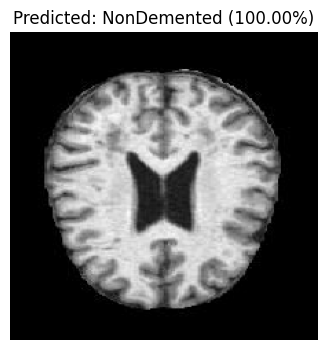

Predicted label: NonDemented
Confidence: 100.00%
Probabilities (in class order):
  MildDemented: 0.00%
  ModerateDemented: 0.00%
  NonDemented: 100.00%
  VeryMildDemented: 0.00%


In [20]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# === 1. Load model from Drive (since you restarted / want permanent model) ===
model_path = "/content/drive/MyDrive/Alzheimer_Model/best_vgg16.h5"
model_for_inference = load_model(model_path)
print("Loaded model from:", model_path)

# class_indices must exist; if you're in same notebook where you trained
# it is already defined from train_gen.class_indices
print("Class indices:", class_indices)

# === 2. Prediction + display function ===
def predict_single_image_and_show(img_path,
                                  model_obj=model_for_inference,
                                  target_size=(224, 224),
                                  class_indices=class_indices):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Predict
    probs = model_obj.predict(x)[0]
    idx = int(np.argmax(probs))
    inv_map = {v: k for k, v in class_indices.items()}
    label = inv_map[idx]
    confidence = float(probs[idx]) * 100.0  # percentage

    # Show image with title
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {label} ({confidence:.2f}%)")
    plt.show()

    # Print details
    print("Predicted label:", label)
    print(f"Confidence: {confidence:.2f}%")
    print("Probabilities (in class order):")
    for c_idx, cls_name in sorted(inv_map.items()):
        print(f"  {cls_name}: {probs[c_idx]*100:.2f}%")

    return label, confidence, probs

# === 3. Upload MRI image(s) and predict ===
print("Upload an MRI image file (jpg/png)...")
uploaded = files.upload()  # shows upload dialog

for fname in uploaded.keys():
    img_path = "/content/" + fname
    print("\nFile received:", img_path)
    label, conf, probs = predict_single_image_and_show(img_path)


Saving VeryMildDemented.jpg to VeryMildDemented (1).jpg


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)



🧠 Predicted Class: VeryMildDemented
📊 Confidence: 100.00%

Prediction Probabilities:
  MildDemented: 0.00%
  ModerateDemented: 0.00%
  NonDemented: 0.00%
  VeryMildDemented: 100.00%


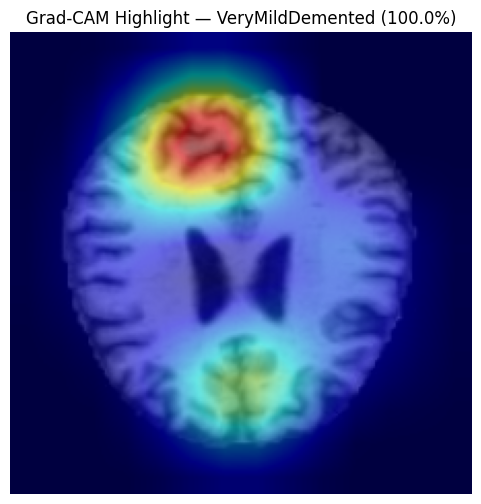

In [21]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def generate_gradcam(model, img_path, layer_name="block5_conv3", size=(224,224)):
    img = image.load_img(img_path, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    img = cv2.imread(img_path)
    img = cv2.resize(img, size)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    return overlay, predictions.numpy()[0]

# -------- Run this to upload image ----------
uploaded = files.upload()
img_path = next(iter(uploaded))  # get uploaded filename

overlay, preds = generate_gradcam(model_for_inference, img_path)

# -------- Display Prediction + Heatmap ----------
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
pred_class = labels[np.argmax(preds)]
confidence = np.max(preds) * 100

print(f"\n🧠 Predicted Class: {pred_class}")
print(f"📊 Confidence: {confidence:.2f}%")
print("\nPrediction Probabilities:")
for i, p in enumerate(preds):
    print(f"  {labels[i]}: {p*100:.2f}%")

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Grad-CAM Highlight — {pred_class} ({confidence:.1f}%)")
plt.show()


Saving Non-Demented.jpg to Non-Demented (1).jpg

🧠 Predicted Class: NonDemented
📊 Confidence: 100.00%

Prediction Probabilities:
  MildDemented: 0.00%
  ModerateDemented: 0.00%
  NonDemented: 100.00%
  VeryMildDemented: 0.00%


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


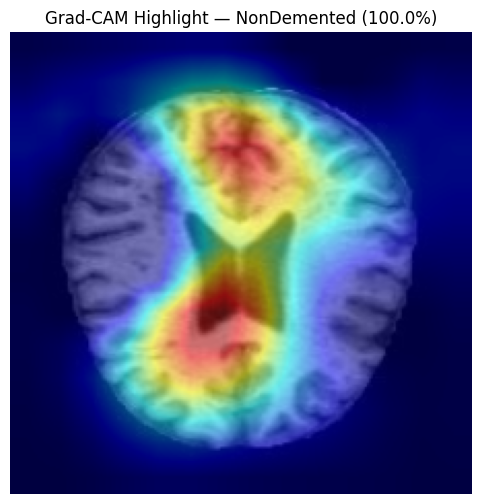

In [28]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def generate_gradcam(model, img_path, layer_name="block5_conv3", size=(224,224)):
    img = image.load_img(img_path, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    img = cv2.imread(img_path)
    img = cv2.resize(img, size)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    return overlay, predictions.numpy()[0]

# -------- Run this to upload image ----------
uploaded = files.upload()
img_path = next(iter(uploaded))  # get uploaded filename

overlay, preds = generate_gradcam(model_for_inference, img_path)

# -------- Display Prediction + Heatmap ----------
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
pred_class = labels[np.argmax(preds)]
confidence = np.max(preds) * 100

print(f"\n🧠 Predicted Class: {pred_class}")
print(f"📊 Confidence: {confidence:.2f}%")
print("\nPrediction Probabilities:")
for i, p in enumerate(preds):
    print(f"  {labels[i]}: {p*100:.2f}%")

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Grad-CAM Highlight — {pred_class} ({confidence:.1f}%)")
plt.show()


Saving Mild Demented.jpg to Mild Demented.jpg

🧠 Predicted Class: MildDemented
📊 Confidence: 100.00%

Prediction Probabilities:
  MildDemented: 100.00%
  ModerateDemented: 0.00%
  NonDemented: 0.00%
  VeryMildDemented: 0.00%


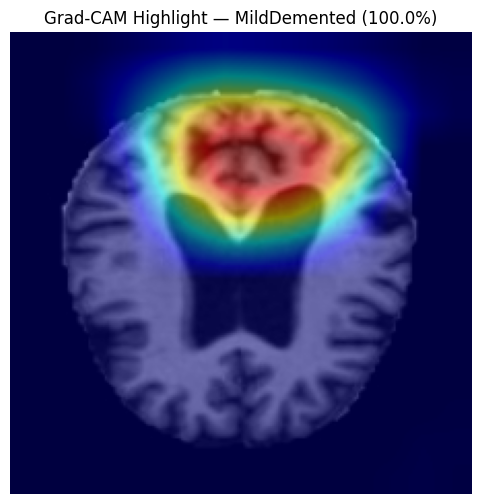

In [30]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def generate_gradcam(model, img_path, layer_name="block5_conv3", size=(224,224)):
    img = image.load_img(img_path, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    img = cv2.imread(img_path)
    img = cv2.resize(img, size)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    return overlay, predictions.numpy()[0]

# -------- Run this to upload image ----------
uploaded = files.upload()
img_path = next(iter(uploaded))  # get uploaded filename

overlay, preds = generate_gradcam(model_for_inference, img_path)

# -------- Display Prediction + Heatmap ----------
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
pred_class = labels[np.argmax(preds)]
confidence = np.max(preds) * 100

print(f"\n🧠 Predicted Class: {pred_class}")
print(f"📊 Confidence: {confidence:.2f}%")
print("\nPrediction Probabilities:")
for i, p in enumerate(preds):
    print(f"  {labels[i]}: {p*100:.2f}%")

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Grad-CAM Highlight — {pred_class} ({confidence:.1f}%)")
plt.show()


Saving Moderated Demented.jpg to Moderated Demented.jpg

🧠 Predicted Class: ModerateDemented
📊 Confidence: 100.00%

Prediction Probabilities:
  MildDemented: 0.00%
  ModerateDemented: 100.00%
  NonDemented: 0.00%
  VeryMildDemented: 0.00%


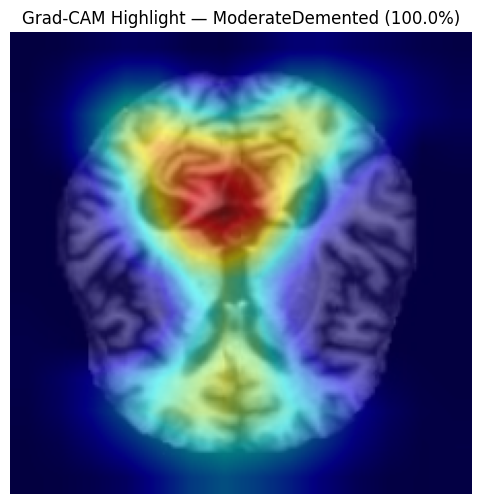

In [31]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def generate_gradcam(model, img_path, layer_name="block5_conv3", size=(224,224)):
    img = image.load_img(img_path, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    img = cv2.imread(img_path)
    img = cv2.resize(img, size)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    return overlay, predictions.numpy()[0]

# -------- Run this to upload image ----------
uploaded = files.upload()
img_path = next(iter(uploaded))  # get uploaded filename

overlay, preds = generate_gradcam(model_for_inference, img_path)

# -------- Display Prediction + Heatmap ----------
labels = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
pred_class = labels[np.argmax(preds)]
confidence = np.max(preds) * 100

print(f"\n🧠 Predicted Class: {pred_class}")
print(f"📊 Confidence: {confidence:.2f}%")
print("\nPrediction Probabilities:")
for i, p in enumerate(preds):
    print(f"  {labels[i]}: {p*100:.2f}%")

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Grad-CAM Highlight — {pred_class} ({confidence:.1f}%)")
plt.show()


207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 169ms/step
pred_probs shape: (6600, 4)
y_true_binary shape: (6600, 4)


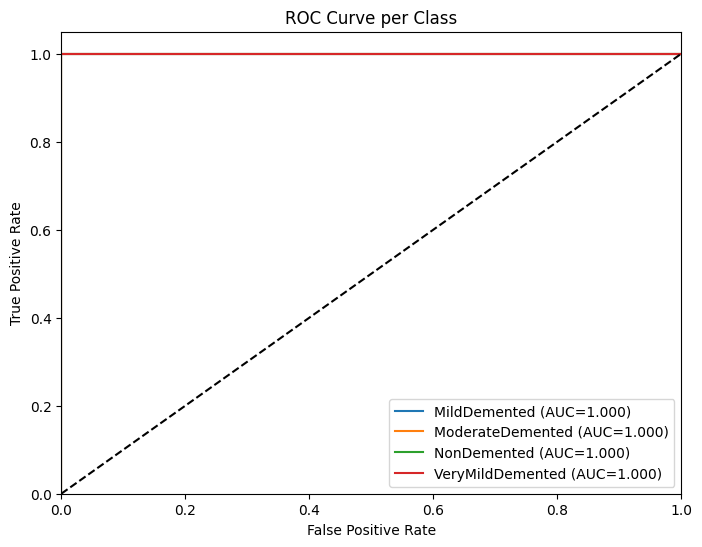

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Get predicted probabilities & true labels again
test_gen.reset()
pred_probs = model_for_inference.predict(test_gen, verbose=1)  # shape: [N, 4]
y_true = test_gen.classes                                      # shape: [N]
labels = list(test_gen.class_indices.keys())                   # ['MildDemented', ...]

# 2. Binarize true labels for ROC
n_classes = len(labels)
y_true_binary = label_binarize(y_true, classes=list(range(n_classes)))  # shape: [N,4]

print("pred_probs shape:", pred_probs.shape)
print("y_true_binary shape:", y_true_binary.shape)

# 3. Plot ROC per class
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend(loc="lower right")
plt.show()


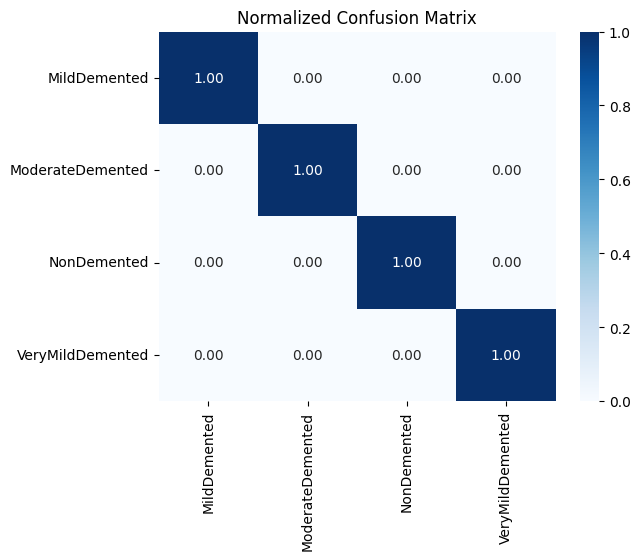

In [23]:
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, cmap="Blues", fmt=".2f",
            xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix")
plt.show()


In [27]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import time

# 1 Upload an MRI image
print("Upload an MRI image (jpg/png) to measure inference time...")
uploaded = files.upload()

# get uploaded filename
fname = next(iter(uploaded.keys()))
img_path = "/content/" + fname
print("File received:", img_path)

# 2 Preprocess image exactly like during training
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

# 3 Measure inference time
t0 = time.time()
_ = model_for_inference.predict(x)
inference_time = time.time() - t0

print(f"\n Inference time per image: {inference_time:.6f} seconds")
print(f" Speed: {1.0/inference_time:.2f} images per second")


Upload an MRI image (jpg/png) to measure inference time...


Saving MildDemented.jpg to MildDemented (1).jpg
File received: /content/MildDemented (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

 Inference time per image: 0.090731 seconds
 Speed: 11.02 images per second
